## Modelling Replication code
This notebook replicates the main results presented in the paper, from training the model to analysing conservation scores.
All data that is needed is in the data_dict.pkl pickle

In [194]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle
from decimal import Decimal
import collections

import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Dont use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils
import utils_data

In [2]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

#### Matplotlib config

In [2]:
import matplotlib_config

In [179]:
reload(matplotlib_config)
matplotlib_config.paper_config()

In [4]:
fig_dims = matplotlib_config.get_figsize(frac=1/3)

#### Utility functions

In [5]:
# Function to compute all test metrics
outputval_names = {"doudna": "rl_mean", "andreev":"log_load", "pcr3":"log_load", "eichhorn":"log_load",
                  "ptr":"ptr", "wilhelm":"ptr"}

def compute_corrs(df, model, one_hot_fn, key, extra_encoding_fn=[]):
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, 
                                                shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    return {"corr":(stats.pearsonr(predict.reshape(-1), df[outputval_names[key]]), 
                               stats.spearmanr(predict.reshape(-1), df[outputval_names[key]])),
            "pred":predict}

def compute_all_test_metrics(data_dict, model, min_len=None, extra_encoding_fn=[],
                            postproc_mean=5.58621521, postproc_sd=1.34657403):
    result_dict = {}
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    # Test sets
    data_df = data_dict["mpra"]
    for key in ['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'human']:
        df = data_df[(data_df.library == key) & (data_df.set == "test")]
        generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
        predict = model.predict_generator(generator, verbose=0)
        if key == "egfp_unmod_1":
            result_dict[key] = (utils.rSquared(predict.reshape(-1), df["rl"]), utils.pearson_r(predict.reshape(-1), df["rl"])[0])
        else:
            result_dict[key] = utils.pearson_r(predict.reshape(-1), df["rl"])[0]
    varlen_df = data_dict["varlen_mpra"]
    for key in ['random', 'human']:
        df = varlen_df[(varlen_df.library == key) & (varlen_df.set == "test")]
        generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
        predict = model.predict_generator(generator, verbose=0)
        if key == "random":
            result_dict[key] = (utils.rSquared(predict.reshape(-1), df["rl"]), utils.pearson_r(predict.reshape(-1), df["rl"])[0])
        if key == "human":
            result_dict["human_varlen"] = utils.pearson_r(predict.reshape(-1), df["rl"])[0]
    # SNV
    df = data_dict["snv"]
    one_hot_fn_mother = utils_data.OneHotEncoder("mother", min_len=min_len)
    gen_wt = utils_data.DataSequence(df, encoding_functions=[one_hot_fn_mother] + extra_encoding_fn, shuffle=False)
    predict_wt = model.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict_snv = model.predict_generator(gen_snv, verbose=0)
    if min_len is not None:
        predict_wt = predict_wt * postproc_sd + postproc_mean
        predict_snv = predict_snv * postproc_sd + postproc_mean
    log_pred_diff = np.log2(predict_snv/predict_wt)
    result_dict["snv"] = utils.pearson_r(log_pred_diff.reshape(-1), df["log_obs_diff"])[0]
    # Endogenous data
    for key in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
        result_dict[key] = compute_corrs(data_dict[key], model, one_hot_fn, key, extra_encoding_fn=extra_encoding_fn)["corr"]
    return result_dict

def compute_split_metrics(data_dict, model, min_len=None, splits=[0, 100], extra_encoding_fn=[]):
    splits2 = splits[1:] + [1000000]
    result_dict = {str(split):{} for split in splits2[:-1]}
    result_dict["long"] = {}
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    for key in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
        print("Analysing set: " + key)
        df = data_dict[key]
        for i in range(len(splits)):
            print("Analysing split from: " + str(splits[i]) + " to: " + str(splits2[i]))
            subset = df[(df.utr.str.len() > splits[i]) & (df.utr.str.len() <= splits2[i])]
            model_result = compute_corrs(subset, model, one_hot_fn, key, extra_encoding_fn=extra_encoding_fn)
            total_corr = model_result["corr"]
            pred = model_result["pred"]
            if i == len(splits) - 1:
                result_key = "long"
            else:
                result_key = str(splits2[i])
            result_dict[result_key][key] = {"corr":(total_corr[0][0], total_corr[1][0]),
                                           "pred":pred.reshape(-1),
                                           "obs":np.array(subset[outputval_names[key]]).reshape(-1)}
    return result_dict

## Read in the data

In [6]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)

In [7]:
for key in data_dict:
    print(key)
    print(len(data_dict[key]))

mpra
980244
snv
1584
ptr
11575
wilhelm
5293
andreev
8003
pcr3
7672
eichhorn
8956
doudna
25831
varlen_mpra
102214


## Training
#### (Skip if not making new model)

### Prepare training data

In [8]:
# length 50 mpra data
one_hot = utils_data.OneHotEncoder("utr")
mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
val_data = mpra_data[(mpra_data.set == "val") & (mpra_data.library == "egfp_unmod_1")]
encoded_mpra_train_50 = one_hot(train_data_50)
encoded_mpra_val = one_hot(val_data)

In [9]:
# variable length (up to 100) mpra data
mpra_data_varlen = data_dict["varlen_mpra"]
train_data = mpra_data_varlen[(mpra_data_varlen.set == "train") & (mpra_data_varlen.library == "random")]
encoded_mpra_train = one_hot(train_data)

In [11]:
# combined length 50 and variable length mpra data
train_data_combined = pd.concat([train_data[["utr", "rl", "library"]], train_data_50[["utr", "rl", "library"]]])
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
generator_combined = utils_data.DataSequence(train_data_combined, encoding_functions=[one_hot_fn, library_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

### Train a Model

In [32]:
reload(model)
utr_model = model.create_frame_slice_model(kernel_size=[7,7,7],
                        only_max_pool=False,
                        padding="same",
                        skip_connections="residual",
                        use_scaling_regression=True, library_size=2)

In [33]:
utr_model.fit_generator(generator_combined, epochs=6, verbose=2)

Epoch 1/6
 - 51s - loss: 4.2901
Epoch 2/6
 - 43s - loss: 0.9584
Epoch 3/6
 - 44s - loss: 0.7636
Epoch 4/6
 - 44s - loss: 0.6082
Epoch 5/6
 - 42s - loss: 0.5072
Epoch 6/6
 - 43s - loss: 0.4667


In [45]:
utr_model.save("../Models/utr_model_combined_residual.h5")

### Evaluate it

In [46]:
utr_model_combined = load_model("..Models/utr_model_combined_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

In [39]:
metrics = compute_all_test_metrics(data_dict, utr_model, extra_encoding_fn=[library_fn])

In [ ]:
for key in metrics:
    print(key)
    print(metrics[key])

In [44]:
# pickle and save
with open("../Data/Metrics/metrics_frameslice_combined_dict.pkl", 'wb') as handle:
    pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [295]:
with open("../Data/Metrics/metrics_frameslice_50_dict.pkl", 'rb') as handle:
    metrics_frameslice_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_100_dict.pkl", 'rb') as handle:
    metrics_frameslice_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_combined_dict.pkl", 'rb') as handle:
    metrics_frameslice_combined = pickle.load(handle)

In [296]:
for key in metrics_frameslice_100:
    print(key)
    print(metrics_frameslice_50[key])
    print(metrics_frameslice_100[key])
    print(metrics_frameslice_combined[key])

egfp_unmod_1
(0.9221064552942099, 0.9286913985005334)
(0.6238430947475788, 0.8626600121588603)
(0.9021292130831058, 0.9097982804043929)
mcherry_1
0.6937217350567138
0.6557430404941327
0.6901184146770003
mcherry_2
0.7625899974346826
0.7168778661688588
0.7495499047058781
egfp_unmod_2
0.8502690102010035
0.8066638829680413
0.8314158699899794
human
0.7779039427378039
0.7043140526130449
0.7515240412710117
random
(-0.02819618345471775, 0.8109036397203787)
(0.79706930893472, 0.814719212159738)
(0.8315714881284952, 0.8348638498491876)
human_varlen
0.7594276408239143
0.7807088113039873
0.79846334514603
snv
0.5317956093905337
0.5247975465973355
0.5369803198493659
doudna
((0.12579558122090928, 1.350383713736952e-91), SpearmanrResult(correlation=0.13118200770847457, pvalue=1.65365573710095e-99))
((0.15630874920080737, 5.825983570910145e-141), SpearmanrResult(correlation=0.15500563120352004, pvalue=1.2613197345253893e-138))
((0.15037564662230432, 1.7119617527074965e-130), SpearmanrResult(correlation

## Get all models

In [13]:
# Load models
utr_model_50 = load_model("../Models/utr_model_avgpool.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
utr_model = load_model("../Models/utr_model_100_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
utr_model_combined = load_model("../Models/utr_model_combined_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
paper_model_orig = load_model("../Models/main_MRL_model.hdf5")
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")
paper_model2 = load_model("../Models/Varying_length_25to100_model.hdf5")

## Plots of Performance on MPRA data

In [58]:
def predict_on_MPRA(model, data_dict, varlen = False, library = "egfp_unmod_1", min_len = None,
                    extra_encoding_fn=[], postproc_mean=5.58621521, postproc_sd=1.34657403):
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    if varlen:
        data_df = data_dict["varlen_mpra"].copy()
    else:
        data_df = data_dict["mpra"].copy()
    df = data_df[(data_df.library == library) & (data_df.set == "test")]
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    if min_len is not None:
        predict = predict * postproc_sd + postproc_mean
    df["pred"] = predict.reshape(-1)
    return df

In [86]:
# Plotting code taken from the Sample et al
def plot_mpra_test(e_test, xlims=(1.5,8), ylims=(1.5,8),
                   fig_dims=(2.5,2),
                   r_squared_pos=(6, 2), r_squared_size=8,
                   color = (0.3, 0.45, 0.69),
                   put_xlabel=True, put_ylabel=True,
                  dot_size=2, font_size=10, alpha=0.2,
                  file=""):
    r_squared = utils.pearson_r(e_test["pred"], e_test["rl"])[0]
    
    #atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
    #n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]

    #c1 = (0.3, 0.45, 0.69)
    #c2 = 'r'
    g = sns.JointGrid(x='rl', y="pred", data=e_test, space=0, xlim=(2,10), ylim=(2,10), height=4)
    g.plot_joint(plt.scatter,s=dot_size, color=color, linewidth=0.2, alpha=alpha, edgecolor='white', 
                 rasterized=True)
    #fig, ax = plt.subplots(figsize=fig_dims)
    #ax.scatter(e_test["rl"], e_test["pred"], s=dot_size, color=color, alpha=alpha, rasterized=True)
    xlabel = "      "
    ylabel = "      "
    if put_xlabel:
        xlabel = 'Observed MRL'
    if put_ylabel:
        ylabel = 'Predicted MRL'
    g.set_axis_labels(xlabel, ylabel, **{'size':font_size})
    fig = g.fig
    ax = fig.gca()
    ax.set_yticks(np.arange(1,9.01, 1));
    ax.set_yticklabels(range(1,10),size=font_size);
    ax.set_xticks(np.arange(1,9.01, 1));
    ax.set_xticklabels(range(1,10),size=font_size);
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlim(xlims[0],xlims[1])
    ax.text(x=r_squared_pos[0], y=r_squared_pos[1], s='r$^2$_P: ' + str(round(r_squared, 3)), 
            size=r_squared_size)
    #g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})

    #g.x = n_atg['rl'].values
    #g.y = n_atg['pred'].values
    #g.plot_joint(plt.scatter, s=dot_size, linewidth=0.2, alpha='0.2', color=c2, edgecolor='white',
    #            rasterized = True)
    #g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
    #f.tight_layout()
    #sns.despine(fig)
    fig.set_size_inches(fig_dims)
    fig.savefig("../Graphics/" + file + ".svg")

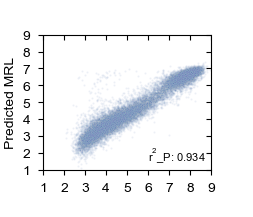

In [92]:
# Optimus 50 on MPRA 50
e_test = predict_on_MPRA(paper_model_orig, data_dict, min_len=50)
plot_mpra_test(e_test,file="mpratest_Optimus50on50",xlims=(1,9), ylims=(1,9), alpha=0.1,
              r_squared_pos=(6, 1.5), put_xlabel=False)

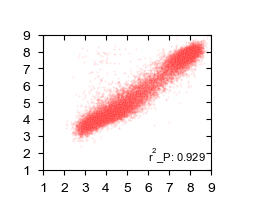

In [93]:
# Frameslice 50 on MPRA 50
e_test = predict_on_MPRA(utr_model_50, data_dict)
plot_mpra_test(e_test,file="mpratest_Framselice50on50",xlims=(1,9), ylims=(1,9), alpha=0.1,
              r_squared_pos=(6, 1.5), color="r", put_xlabel=False, put_ylabel=False)

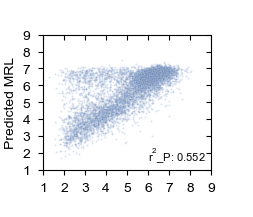

In [94]:
# Optimus50 on MPRA 100
e_test = predict_on_MPRA(paper_model_orig, data_dict, varlen=True, library="random", min_len=50)
plot_mpra_test(e_test,file="mpratest_Optimus50on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              put_xlabel=False)

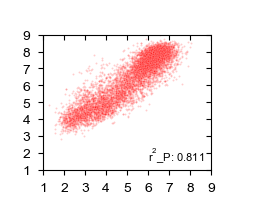

In [95]:
# Frameslice50 on MPRA 100
e_test = predict_on_MPRA(utr_model_50, data_dict, varlen=True, library="random")
plot_mpra_test(e_test,file="mpratest_Frameslice50on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color='r', put_xlabel=False, put_ylabel=False)

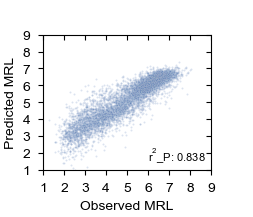

In [96]:
# Optimus 100 on MPRA 100
varlen_mean = train_data["rl"].mean()
varlen_sd = train_data["rl"].std()
e_test = predict_on_MPRA(paper_model2, data_dict, varlen=True, library="random", min_len=100,
                        postproc_mean=varlen_mean,postproc_sd=varlen_sd)
plot_mpra_test(e_test,file="mpratest_Optimus100on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5))

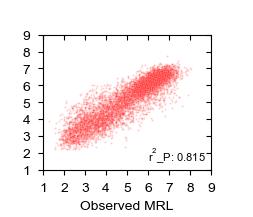

In [97]:
# Frameslice 100 on MPRA 100
e_test = predict_on_MPRA(utr_model, data_dict, varlen=True, library="random")
plot_mpra_test(e_test,file="mpratest_Frameslice100on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color="r", put_ylabel=False)

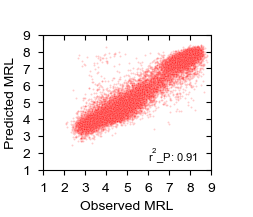

In [63]:
# Frameslice combined on MPRA 50
e_test = predict_on_MPRA(utr_model_combined, data_dict, extra_encoding_fn=[library_fn])
plot_mpra_test(e_test,file="mpratest_FramesliceCombinedon50", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color="r")

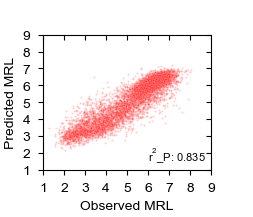

In [64]:
# Frameslice combined on MPRA 100
e_test = predict_on_MPRA(utr_model_combined, data_dict, varlen=True, library="random", extra_encoding_fn=[library_fn])
plot_mpra_test(e_test,file="mpratest_FramesliceCombinedon100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color="r")

### Metrics Comparison Plot

#### Compute split metrics

In [ ]:
metrics_split_optimus_50 = compute_split_metrics(data_dict, paper_model, min_len=50, splits=[0, 50])
metrics_split_frameslice_50 = compute_split_metrics(data_dict, utr_model_50, splits=[0, 50])

In [ ]:
metrics_split_optimus_100 = compute_split_metrics(data_dict, paper_model2, min_len=100)
metrics_split_frameslice_100 = compute_split_metrics(data_dict, utr_model)

In [ ]:
metrics_split_frameslice_combined = compute_split_metrics(
    data_dict, utr_model_combined, extra_encoding_fn=[library_fn])

In [ ]:
#metrics_split_recurrent_100 = compute_split_metrics(data_dict, utr_model_rec, extra_encoding_fn=[frame_encoder_fn])

In [60]:
with open("../Data/Metrics/metrics_split_optimus_50_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_optimus_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_50_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_optimus_100_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_optimus_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_100_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_combined_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_combined, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [63]:
with open("../Data/Metrics/metrics_split_recurrent_100_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_recurrent_100, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
with open("../Data/Metrics/metrics_split_frameslice_50_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_optimus_50_dict.pkl", 'rb') as handle:
    metrics_split_optimus_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_frameslice_100_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_optimus_100_dict.pkl", 'rb') as handle:
    metrics_split_optimus_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_frameslice_combined_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_combined = pickle.load(handle)

In [ ]:
with open("../Data/Metrics/metrics_split_recurrent_100_dict.pkl", 'rb') as handle:
    metrics_split_recurrent_100 = pickle.load(handle) 

#### Plot split metrics

In [200]:
corr_type_dict = {"pearson":0, "spearman":1}

def plot_metrics(metrics, metrics_paper, split="long", model="slice100", corr_type="spearman",
                fig_dims=(3.75, 3.0), font_size=10, font_size_lbl=8, n_samples=100, dot_size=10,
                suppress_lbls=False, std_factor=3, suppress_legend=True):
    ordered_keys = ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]
    #labels = ["Floor (TripSeq)", "Andreev (RiboSeq)", "Xiao (RiboSeq)", "Eichhorn (RiboSeq)",
    #         "Eraslan (PTR)", "Wilhelm (PTR)"]
    labels = ["Floor", "Andreev", "Xiao", "Eichhorn", "Eraslan", "Wilhelm"]
    y = [metrics[split][key]["corr"][corr_type_dict[corr_type]] 
         for key in ordered_keys]
    x = [metrics_paper[split][key]["corr"][corr_type_dict[corr_type]]
         for key in ordered_keys]
    color = []
    bar_our = []
    bar_paper = []
    error_bar = []
    for idx,key in enumerate(ordered_keys):
        new_df = pd.DataFrame({"pred_paper":metrics_paper[split][key]["pred"],
                              "obs_paper":metrics_paper[split][key]["obs"],
                              "pred":metrics[split][key]["pred"],
                                "obs":metrics[split][key]["obs"]})
        our_bootstrap = []
        paper_bootstrap = []
        for i in range(n_samples):
            sub = new_df.sample(frac=1, replace=True)
            if corr_type == "pearson":
                our_bootstrap.append(stats.pearsonr(sub["pred"], sub["obs"])[0])
                paper_bootstrap.append(stats.pearsonr(sub["pred_paper"], sub["obs_paper"])[0])
            else:
                our_bootstrap.append(stats.spearmanr(sub["pred"], sub["obs"])[0])
                paper_bootstrap.append(stats.spearmanr(sub["pred_paper"], sub["obs_paper"])[0])
        
        diff = [x - y for x,y in zip(our_bootstrap, paper_bootstrap)]
        mean_diff = np.mean(diff)
        #print(mean_diff)
        error_diff = np.std(diff)*std_factor
        #print(error_diff)
        #error_bar.append(np.std(diff)*2)
        if mean_diff < 0 and mean_diff + error_diff > 0:
            color.append("grey")
        elif mean_diff > 0 and mean_diff - error_diff < 0:
            color.append("grey")
        else:
            color.append("black")
        
        #bar_our.append(np.std(our_bootstrap)*2)
        #bar_paper.append(np.std(paper_bootstrap)*2)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 0.3)

    line = np.linspace(*ax.get_xlim())
    ax.plot(line, line, color="black")
    
    if not suppress_lbls:
        ax.set_xlabel("Spearman Corr with \n Optimus Predictions",fontsize=font_size)
        ax.set_ylabel("Spearman Corr with \n Frameslice Predictions",fontsize=font_size)
    ax.tick_params(labelsize=font_size)

    ax.scatter(x,y, c=color, s=dot_size)
    #ax.errorbar(x, y, xerr=bar_paper, yerr=bar_our, capsize=8, ecolor = "k", fmt=' ')
    
    if not suppress_legend:
        symbols = ([Line2D([0], [0], marker='o', color='w', label='Significant',
                          markerfacecolor='black', markersize=3),
                   Line2D([0], [0], marker='o', color='w', label='Not Significant',
                          markerfacecolor='grey', markersize=3)])
        ax.legend(handles=symbols, frameon=False)
    
    for i, txt in enumerate(labels):
        ax.annotate(txt, (x[i], y[i]), fontsize=font_size_lbl)
        # Diag error bars
        # ax.plot(np.linspace(x[i] - error_bar[i], x[i] + error_bar[i]), 
        #         np.flip(np.linspace(y[i] - error_bar[i], y[i] + error_bar[i])), 
        #         color="black")
    
    sns.despine(fig)
    
    fig.savefig("../Graphics/metrics_plot_" + model + "_" + split + ".svg")

In [191]:
fig_dims = (2.5, 2.0)
font_size = 10
font_size_lbl = 8

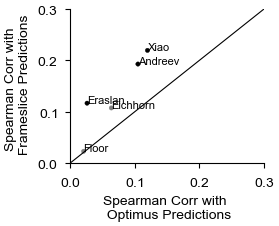

In [192]:
plot_metrics(metrics_split_frameslice_50, metrics_split_optimus_50, split="50", model="slice50", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples=100)

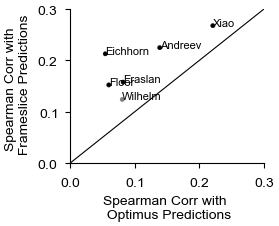

In [155]:
plot_metrics(metrics_split_frameslice_50, metrics_split_optimus_50, split="long", model="slice50", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples=100)

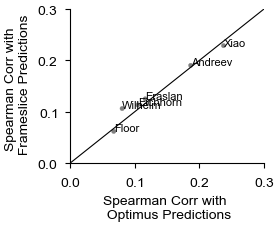

In [156]:
plot_metrics(metrics_split_frameslice_100, metrics_split_optimus_100, split="100", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples = 100)

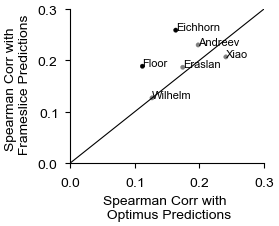

In [157]:
plot_metrics(metrics_split_frameslice_100, metrics_split_optimus_100, split="long", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples = 100)

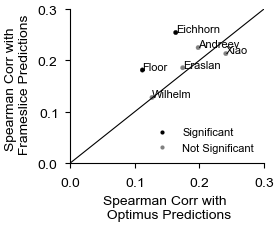

In [201]:
# combined model
plot_metrics(metrics_split_frameslice_combined, metrics_split_optimus_100, split="long", model="slice_combined", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples = 100, suppress_legend=False)

### MPRA SNV Effect

In [14]:
df = data_dict["snv"]
frame_encoder_fn = utils_data.FrameEncoder("utr")
one_hot_fn = utils_data.OneHotEncoder("utr")
frame_encoder_fn_mother = utils_data.FrameEncoder("mother")
one_hot_fn_mother = utils_data.OneHotEncoder("mother")
gen_wt = utils_data.DataSequence(df, encoding_functions=[one_hot_fn_mother], shuffle=False)
predict_wt = utr_model.predict_generator(gen_wt, verbose=0)
gen_snv = utils_data.DataSequence(df, encoding_functions=[one_hot_fn], shuffle=False)
predict_snv = utr_model.predict_generator(gen_snv, verbose=0)
log_pred_diff = np.log2(predict_snv/predict_wt)
df["log_pred_diff"] = log_pred_diff
r_squared_snv = utils.pearson_r(log_pred_diff.reshape(-1), df["log_obs_diff"])[0]

In [15]:
df_big = df[np.abs(df.log_obs_diff) > 0.5]
stats.pearsonr(df_big["log_pred_diff"], df_big["log_obs_diff"])[0] ** 2

0.7735761238904573

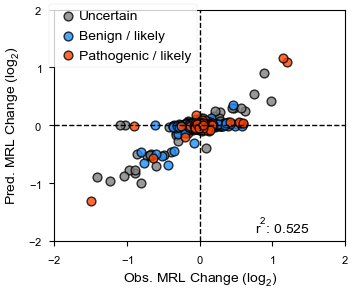

In [16]:
point_size = 40
font_size = 10
fig_dims = (3.75, 3.0)

# SNV data
sub = df[df['obs_diff'] != 0.0]

# Select high quality data - average 30 reads per fraction
sub = sub[sub['total'] >= 620]

path_list = ['Pathogenic', 'Likely pathogenic', 'Pathogenic, other', 'Pathogenic/Likely pathogenic']
benign_list = ['Benign/Likely benign', 'Benign', 'Likely Benign']
uncertain_list = ['Conflicting interpretations of pathogenicity', 'Uncertain significance']

path = sub[(sub['clin_sig'] == path_list[0]) | (sub['clin_sig'] == path_list[1]) |
           (sub['clin_sig'] == path_list[2]) | (sub['clin_sig'] == path_list[3])]
non = sub[(sub['clin_sig'] == benign_list[0]) | (sub['clin_sig'] == benign_list[1]) | (sub['clin_sig'] == benign_list[2])]
unsure = sub[(sub['clin_sig'] == uncertain_list[0]) | (sub['clin_sig'] == uncertain_list[1])]

f, ax = plt.subplots()
f.set_size_inches(fig_dims)

ax.scatter(unsure['log_obs_diff'], unsure['log_pred_diff'], alpha=0.8, color='grey', label='Uncertain',
           linewidth=1, edgecolors='k', s=point_size)
ax.scatter(non['log_obs_diff'], non['log_pred_diff'], alpha=0.8, color='dodgerblue', label='Benign / likely',
           linewidth=1, edgecolors='k', s=point_size)
ax.scatter(path['log_obs_diff'], path['log_pred_diff'], alpha=0.8, color='orangered', label='Pathogenic / likely',
           linewidth=1, edgecolors='k', s=point_size)

ax.set_ylabel('Pred. MRL Change (log$_2$)', fontsize=font_size)
ax.set_xlabel('Obs. MRL Change (log$_2$)', fontsize=font_size)
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))
ax.hlines(y=0,xmin=-2, xmax=2, linestyles='dashed', linewidth=1)
ax.vlines(x=0,ymin=-2, ymax=2, linestyles='dashed', linewidth=1)
ax.text(x=0.69, y=0.03, s='r$^2$: ' + str(round(r_squared_snv, 3)), transform=ax.transAxes, size=font_size)
ax.legend(loc=(-0.02,0.75), handletextpad=-0.2, fontsize=font_size)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

f.savefig("../Graphics/snv.svg")

## TIS Strength validation

#### Impact of AUG context on predicted SNV effect

In [17]:
noderer_df_aug = pd.read_csv("../Data/TIS/tis_efficiencies_aug.tsv", sep='\t')
noderer_df_aug = noderer_df_aug.rename(index=str, columns={"sequence":"TIS_Sequence", "efficiency":"TIS_Efficiency"})
noderer_df_nonaug = pd.read_csv("../Data/TIS/tis_efficiencies_nonaug.tsv", sep='\t')

# Recode U to T
noderer_df_aug["TIS_Sequence"] = noderer_df_aug["TIS_Sequence"].str.replace("U", "T")
noderer_df_nonaug["TIS_Sequence"] = noderer_df_nonaug["TIS_Sequence"].str.replace("U", "T")

# Prepare injection
noderer_df_aug["TIS_Sequence_AGG"] = [seq[:7] + "G" + seq[8:] for seq in noderer_df_aug["TIS_Sequence"]]
bad_end = noderer_df_aug["TIS_Sequence"].str.endswith("AT")
double_trouble = noderer_df_aug["TIS_Sequence_AGG"].str.contains("ATG")
noderer_df_aug_sub = noderer_df_aug[(~bad_end) & (~double_trouble)]
noderer_df_aug = noderer_df_aug_sub

In [55]:
extra_encoding_fn = [library_fn]
model_to_apply = utr_model_combined

one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
diffs = []
for i in range(samples):
    prefix = ''.join(random.choices(["C","T","G"], k=9))
    suffix = ''.join(random.choices(["C","T","G"], k=9))
    noderer_df_aug["snv"] = [prefix + seq + suffix for seq in
                                            noderer_df_aug["TIS_Sequence"]]
    noderer_df_aug["wt"] = [prefix + seq + suffix for seq in
                                        noderer_df_aug["TIS_Sequence_AGG"]]
    gen_wt = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                     shuffle=False)
    predict_wt_only = model_to_apply.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                      shuffle=False)
    predict_snv_only = model_to_apply.predict_generator(gen_snv, verbose=0)
    log_pred_diff_only = np.log2(predict_snv_only/predict_wt_only)
    diffs.append(log_pred_diff_only)
diffs = sum(diffs)/len(diffs)
noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)
print(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
print(stats.spearmanr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))

(-0.7946999837983739, 0.0)
SpearmanrResult(correlation=-0.7648457052769003, pvalue=0.0)


In [260]:
with open("../Data/tis_aug_diffs.pkl", 'wb') as handle:
    pickle.dump(diffs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [261]:
with open("../Data/tis_aug_diffs.pkl", 'rb') as handle:
    diffs = pickle.load(handle)

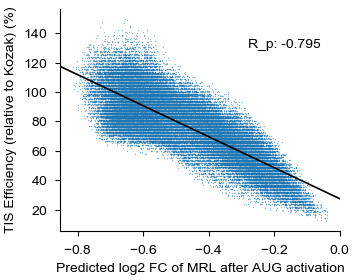

In [207]:
font_size = 10
fig_dims = (3.75, 3.0)

x = sns.regplot(x='Predicted log2 Fold Change', y="TIS_Efficiency", data=noderer_df_aug, ci=None, line_kws={"color":"black"}, 
                scatter_kws={"s": 1, "alpha":0.5, "rasterized":True})
x.set_xlabel("Predicted log2 FC of MRL after AUG activation",fontsize=font_size)
x.set_ylabel("TIS Efficiency (relative to Kozak) (%)",fontsize=font_size)
x.text(x=-0.28, y=130, s='R_p: ' + 
       str(round(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1))[0], 3)), size=font_size)
x.tick_params(labelsize=font_size)
f = x.get_figure()
f.set_size_inches(fig_dims)
f.tight_layout()
sns.despine(f)
f.savefig("../Graphics/Tis_Aug_rasta.svg")

#### Nonaug starts and their context

In [24]:
atg_trouble = noderer_df_nonaug["TIS_Sequence"].str.contains("ATG")
noderer_df_nonaug = noderer_df_nonaug[~atg_trouble]

In [33]:
extra_encoding_fn = [library_fn]
model_to_apply = utr_model_combined

nonaug_dict = {key:noderer_df_nonaug[noderer_df_nonaug["TIS_Sequence"].str[-4:-1] == key] for key in
               set(noderer_df_nonaug["TIS_Sequence"].str[-4:-1])}
key_to_inactive = {'CTG':"CTT", 'ACG':"ACT", 'AAG':"AAC", 'GTG':"GTT", 
                   'ATA':"ATT", 'AGG':"AGT", 'ATT':"GTT", 'ATC':"GTC", 
                   'TTG':"TTT"}
metrics_nonaug = {}
one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
for key in nonaug_dict.keys():
    nonaug_dict[key]["TIS_inactive"] = [seq[:-4] + key_to_inactive[key] + seq[-1] for seq in
                                        nonaug_dict[key]["TIS_Sequence"]]
    diff_list = []
    for i in range(samples):
        prefix = ''.join(random.choices(["C","T","G"], k=9))
        suffix = ''.join(random.choices(["C","T","G"], k=9))
        nonaug_dict[key]["snv"] = [prefix + seq + suffix for seq in
                                            nonaug_dict[key]["TIS_Sequence"]]
        nonaug_dict[key]["wt"] = [prefix + seq + suffix for seq in
                                        nonaug_dict[key]["TIS_inactive"]]
        gen_wt = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                         shuffle=False)
        predict_wt_nonaug = model_to_apply.predict_generator(gen_wt, verbose=0)
        gen_snv = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                          shuffle=False)
        predict_snv_nonaug = model_to_apply.predict_generator(gen_snv, verbose=0)
        log_pred_diff_nonaug = np.log2(predict_snv_nonaug/predict_wt_nonaug)
        diff_list.append(log_pred_diff_nonaug)
    diffs = sum(diff_list)/len(diff_list)    
    metrics_nonaug[key] = (stats.pearsonr(nonaug_dict[key]["TIS_Efficiency"], diffs.reshape(-1)),
                              stats.spearmanr(nonaug_dict[key]["TIS_Efficiency"], diffs.reshape(-1)))
    nonaug_dict[key]["Predicted log2 Fold Change"] = diffs

In [34]:
metrics_nonaug

{'ACG': ((-0.5208540149337733, 4.477573666051672e-70),
  SpearmanrResult(correlation=-0.4117255417033055, pvalue=7.174094470422214e-42)),
 'AAG': ((-0.0694760261690944, 0.028661985664739088),
  SpearmanrResult(correlation=-0.07312663209671151, pvalue=0.021257516075557283)),
 'TTG': ((-0.023506396640644286, 0.4595870883334633),
  SpearmanrResult(correlation=-0.14605388870351163, pvalue=3.853922584714896e-06)),
 'CTG': ((-0.4871139617820911, 3.0600212870794866e-60),
  SpearmanrResult(correlation=-0.4042290948132368, pvalue=2.7619407240386374e-40)),
 'ATA': ((0.06337329029664547, 0.045988739798082955),
  SpearmanrResult(correlation=0.0600073019944047, pvalue=0.05885007779188783)),
 'GTG': ((-0.5324825227951455, 4.421531873413513e-69),
  SpearmanrResult(correlation=-0.31525232211838683, pvalue=7.371783124546117e-23)),
 'ATC': ((0.0009714565996250884, 0.9756216725572221),
  SpearmanrResult(correlation=0.008568375709274975, pvalue=0.7875183787428974)),
 'AGG': ((-0.15533829061571225, 8.82211

In [384]:
with open("../Data/nonaug_dict.pkl", 'wb') as handle:
    pickle.dump(nonaug_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open("../Data/nonaug_dict.pkl", 'rb') as handle:
    nonaug_dict = pickle.load(handle)

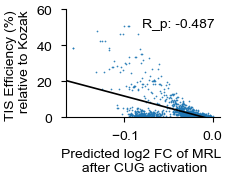

In [206]:
font_size = 10
fig_dims = (2.5, 2.0)

noderer_df_cug = nonaug_dict["CTG"]
x = sns.regplot(x='Predicted log2 Fold Change', y="TIS_Efficiency", data=noderer_df_cug, ci=None, line_kws={"color":"black"}, 
                scatter_kws={"s": 1.5, "alpha":0.9, "rasterized":True})
#x.set_title("Predicted uAUG SNV Impact on CDK2NA varies with context", fontsize=13)
x.set_xlabel("Predicted log2 FC of MRL \n after CUG activation",fontsize=font_size)
x.set_ylabel("TIS Efficiency (%) \n relative to Kozak",fontsize=font_size)
x.set_ylim(0,60)
x.text(x=-0.08, y=50, s='R_p: ' + 
       str(round(stats.pearsonr(noderer_df_cug["TIS_Efficiency"], noderer_df_cug["Predicted log2 Fold Change"])[0], 3)), 
       size=font_size)
x.tick_params(labelsize=font_size)
f = x.get_figure()
f.set_size_inches(fig_dims)
f.tight_layout()
sns.despine(f)
f.savefig("../Graphics/Tis_Cug_rasta.svg")

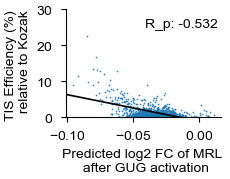

In [204]:
font_size = 10
fig_dims = (2.5, 2.0)

noderer_df_gug = nonaug_dict["GTG"]
x = sns.regplot(x='Predicted log2 Fold Change', y="TIS_Efficiency", data=noderer_df_gug, ci=None, line_kws={"color":"black"}, 
                scatter_kws={"s": 1.5, "alpha":0.9, "rasterized":True})
#x.set_title("Predicted uAUG SNV Impact on CDK2NA varies with context", fontsize=13)
x.set_xlabel("Predicted log2 FC of MRL \n after GUG activation",fontsize=font_size)
x.set_ylabel("TIS Efficiency (%) \n relative to Kozak",fontsize=font_size)
x.set_ylim(0,30)
x.text(x=-0.041, y=25, s='R_p: ' + 
       str(round(stats.pearsonr(noderer_df_gug["TIS_Efficiency"], noderer_df_gug["Predicted log2 Fold Change"])[0], 3)), 
       size=font_size)
x.tick_params(labelsize=font_size)
f = x.get_figure()
f.set_size_inches(fig_dims)
f.tight_layout()
sns.despine(f)
f.savefig("../Graphics/Tis_Gug_rasta.svg")

### Nonaug Sequences (Behaviour on validation set w/o AUG)

#### Structure

In [468]:
df_struct = data_dict["mpra"][(data_dict["mpra"].library == "egfp_unmod_1") & 
                              (data_dict["mpra"].set == "val") &
                           (data_dict["mpra"]["utr"].str.contains("ATG") == False)]
struct_encoded = one_hot_fn(df_struct)
df_struct["pred"] = utr_model.predict(struct_encoded).reshape(-1)

In [485]:
print(stats.pearsonr(df_struct["rl"], -df_struct["utr_energy"]))
print(stats.pearsonr(df_struct["pred"], -df_struct["utr_energy"]))

(-0.4138369862686264, 0.0)
(-0.3868906590876969, 5.126736852373471e-286)


#### GC Content

In [484]:
print(stats.pearsonr(df_struct["rl"], (df_struct["utr"].str.count("G") + df_struct["utr"].str.count("C"))/50))
print(stats.pearsonr(df_struct["pred"], (df_struct["utr"].str.count("G") + df_struct["utr"].str.count("C"))/50))

(-0.44837195689996423, 0.0)
(-0.5972601394242041, 0.0)


## Conservation

In [121]:
from kipoiseq.extractors import FastaStringExtractor
from kipoiseq.extractors import MultiSampleVCF, VariantSeqExtractor
from kipoiseq.dataloaders.sequence import BedDataset
from kipoiseq.utils import to_scalar

import pybedtools
from pybedtools import BedTool, Interval

Write predictions for all possible snv in all 5utr in lof genes

In [160]:
# Function to create an in-silico SNP array
nuc_dict = {'a':[1.0,0.0,0.0,0.0],'c':[0.0,1.0,0.0,0.0],'g':[0.0,0.0,1.0,0.0], 'u':[0.0,0.0,0.0,1.0], 
            't':[0.0,0.0,0.0,1.0], 'n':[0.0,0.0,0.0,0.0], 'x':[1/4,1/4,1/4,1/4]}
permutation_array = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,0.0,0.0,1.0]])

def create_permutations(seq, min_len=None):
    n = len(seq) * 4
    seq = seq.lower()
    one_hot = np.array([nuc_dict[x] for x in seq])
    one_hot_permuted = np.repeat(one_hot[np.newaxis,:,:], n, axis=0)
    for i in range(len(seq)):
        one_hot_permuted[i*4:(i*4)+4,i] = permutation_array
    if min_len is not None:
        diff = min_len - len(seq)
        if diff > 0:
            padding = np.zeros((n+1,diff, 4))
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
            one_hot_permuted = np.concatenate([padding, one_hot_permuted], axis=1)
        if diff < 0:
            one_hot_permuted = one_hot_permuted[np.abs(diff)*4:,np.abs(diff):,:]
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,np.abs(diff):,:], one_hot_permuted], axis=0)
        if diff == 0:
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    else:
        one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    return one_hot_permuted

def create_snv_array(seq, model, min_len=None,
                     postproc_mean=5.58621521, postproc_sd=1.34657403,
                    add_frame=False, add_library=False, suppress_postproc=False):
    if add_frame:
        frame = utils.build_frame(len(seq), (len(seq)*4) + 1)
        predictions = model.predict([create_permutations(seq, min_len=min_len), frame])
    elif add_library:
        indicator = np.zeros(((len(seq)*4) + 1,2))
        indicator[:,1] = 1
        predictions = model.predict([create_permutations(seq, min_len=min_len), indicator])
    else:
        predictions = model.predict(create_permutations(seq, min_len=min_len))
    if min_len is not None and not suppress_postproc:
        predictions =  predictions * postproc_sd + postproc_mean
    delta = np.log2(predictions[1:]/predictions[0])
    if min_len is not None and len(seq) > min_len:
        delta = delta.reshape((min_len, 4))
        diff = len(seq) - min_len
        padding = np.zeros((diff, 4))
        delta = np.concatenate([padding, delta], axis=0)
    else:
        delta = delta.reshape((len(seq), 4))
    return delta

def write_arrays(df, model, path, min_len=None, add_frame=False, add_library=False,
                 suppress_postproc=False,
                check_and_skip=False):
    for seq_id, seq in zip(df["EnsemblTranscriptID"], df["utr"]):
        if len(seq) == 1:
            continue
        if check_and_skip and os.path.exists(path + "SNPdelta_" + seq_id + ".npy"):
            continue
        delta = create_snv_array(seq, model, min_len=min_len, add_frame=add_frame, add_library=add_library,
                                suppress_postproc=suppress_postproc)
        np.save(path + "SNPdelta_" + seq_id + ".npy", np.transpose(delta))

def read_array(pos_df, transcript_id, base_path = "../Data/All_Variants/",
              snv_path="Genecode_v19_new/", cons_path="phylop/"):
    array = np.load(base_path + snv_path + "SNPdelta_" + transcript_id + ".npy")
    pos = pos_df[pos_df.EnsemblTranscriptID == transcript_id].iloc[0]
    indices = np.concatenate([np.arange(x[0],x[1]) for x in eval(pos["pos"])])
    atg_dist = np.flip(np.arange(len(indices))) + 1
    conservation = np.load(base_path + cons_path + "phyloP_" + transcript_id + ".npy")
    if pos["strand"] == "-":
        indices = np.flip(indices)
        conservation = np.flip(conservation)
    return pd.DataFrame({"EnsemblTranscriptID":pos["EnsemblTranscriptID"], 
                         "chr":pos["chr"], "strand":pos["strand"], "pos_ensembl":indices+1,
                         "dist_to_atg":atg_dist,
                         "conservation":conservation,
                        "A":array[0,:],"C":array[1,:],"G":array[2,:],"T":array[3,:]})

def read_all_arrays(pos_df, snv_path="Genecode_v19_frameslice_100/"):
    data = []
    i = 0
    for transcript_id in pos_df["EnsemblTranscriptID"]:
        arr = read_array(pos_df, transcript_id, snv_path=snv_path)
        data.append(arr)
        if i % 1000 == 0:
            print(i)
        i += 1
    arr = pd.concat(data)
    return arr

In [159]:
seq_df = pd.read_csv("../Data/gencodev19_5utr_seq.csv")
pos_df = pd.read_csv("../Data/gencodev19_5utr_pos.csv")
# remove length 1 utrs, as they can not yield sensible predictions and only mess with numpy
seq_df = seq_df[seq_df["utr"].str.len() > 1]
pos_df = pos_df[pos_df["EnsemblTranscriptID"].
                isin(seq_df[seq_df["utr"].str.len() > 1]["EnsemblTranscriptID"])]
# reduce to lof intolerant genes
# Lof intolerant: "oe_lof_upper" < 0.35
lof_df = pd.read_csv("../Data/GTF/gencodev19_5utr_lof.bed", sep="\t",
                     names=["chr", "start", "stop", "EnsemblTranscriptID", "?", "strand"])
pos_df = pos_df[pos_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]
seq_df = seq_df[seq_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]

In [127]:
write_arrays(seq_df, utr_model, "../Data/All_Variants/Genecode_v19_frameslice_100/")

In [91]:
write_arrays(seq_df, utr_model_combined, "../Data/All_Variants/Genecode_v19_frameslice_combined/", add_library=True)

In [161]:
# write for utr model with truncation
write_arrays(seq_df, utr_model, "../Data/All_Variants/Genecode_v19_frameslice_100_truncated/", min_len=100, suppress_postproc=True)

In [316]:
seq_df_100 = seq_df["EnsemblTranscriptID"][seq_df["utr"].str.len() <= 100]
seq_df_long = seq_df["EnsemblTranscriptID"][seq_df["utr"].str.len() > 100]

In [389]:
# write arrays for paper model
write_arrays(seq_df[seq_df["EnsemblTranscriptID"].isin(seq_df_100)], paper_model2, 
                    "../Data/All_Variants/Genecode_v19_paper/", min_len=100)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in log2


In [498]:
# write arrays for paper model with truncation
write_arrays(seq_df, paper_model2, 
                    "../Data/All_Variants/Genecode_v19_paper_truncated/", min_len=100)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in log2


Compare predicted snv effects to conservation score

In [162]:
arr = read_all_arrays(pos_df)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [163]:
arr_truncated = read_all_arrays(pos_df, snv_path="Genecode_v19_frameslice_100_truncated/")

0
1000
2000
3000
4000
5000
6000
7000
8000


In [164]:
arr_paper_truncated = read_all_arrays(pos_df, snv_path="Genecode_v19_paper_truncated/")

0
1000
2000
3000
4000
5000
6000
7000
8000


In [173]:
arr["avg_effect"] = np.sum(np.abs(np.array(arr[["A","C","G","T"]])), axis = 1)/3
arr_truncated["avg_effect"] = np.sum(np.abs(np.array(arr_truncated[["A","C","G","T"]])), axis = 1)/3
arr_paper_truncated["avg_effect"] = np.sum(np.abs(np.array(arr_paper_truncated[["A","C","G","T"]])), axis = 1)/3
arr_far = arr[arr["dist_to_atg"] > 100]
arr_truncated = arr_truncated[arr_truncated["dist_to_atg"] <= 100]
arr_paper_truncated = arr_paper_truncated[arr_paper_truncated["dist_to_atg"] <= 100]

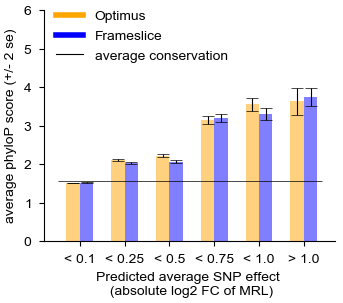

In [256]:
fig_dims = (3.75, 3.0)
font_size = 10
capsize = 4.5

w = 0.3
colors = ["orange", "blue"]

cuts = [0, 0.1, 0.25, 0.5, 0.75, 1.0]
cuts2 = cuts[1:] + [100]
scores_paper = []
scores = []
scores_long = []
sem_paper = []
sem = []
sem_long = []
counts_paper = []
counts = []
counts_long = []
for l,u in zip(cuts, cuts2):
    #paper
    scores_paper.append(arr_paper_truncated[(arr_paper_truncated["avg_effect"] < u) & 
                                            (arr_paper_truncated["avg_effect"] > l)]["conservation"].mean())
    sem_paper.append(arr_paper_truncated[(arr_paper_truncated["avg_effect"] < u) & 
                                         (arr_paper_truncated["avg_effect"] > l)]["conservation"].sem() * 2)
    counts_paper.append(len(arr_paper_truncated[(arr_paper_truncated["avg_effect"] < u) & 
                                                (arr_paper_truncated["avg_effect"] > l)]))
    # ours
    scores.append(arr_truncated[(arr_truncated["avg_effect"] < u) & (arr_truncated["avg_effect"] > l)]["conservation"].mean())
    sem.append(arr_truncated[(arr_truncated["avg_effect"] < u) & (arr_truncated["avg_effect"] > l)]["conservation"].sem() * 2)
    counts.append(len(arr_truncated[(arr_truncated["avg_effect"] < u) & (arr_truncated["avg_effect"] > l)]))
    # ours long
    scores_long.append(arr_far[(arr_far["avg_effect"] < u) & (arr_far["avg_effect"] > l)]["conservation"].mean())
    sem_long.append(arr_far[(arr_far["avg_effect"] < u) & (arr_far["avg_effect"] > l)]["conservation"].sem() * 2)
    counts_long.append(len(arr_far[(arr_far["avg_effect"] < u) & (arr_far["avg_effect"] > l)]))
x_pos = np.arange(len(scores))
names = ["< " + str(x) for x in cuts2[:-1]] + ["> " + str(cuts[-1])]

# Build the plot
fig, ax = plt.subplots()
paper_pos = x_pos-(w/2)
ax.bar(paper_pos, scores_paper, width=w, align='center', alpha=0.5, ecolor='black', capsize=10,
       color=colors[0], label="Optimus")
(_, caps, _) = ax.errorbar(paper_pos, scores_paper, sem_paper, capsize=capsize, ecolor = "k", fmt=' ')
for cap in caps:
    cap.set_color('k')
    cap.set_markeredgewidth(0.5)
our_pos = x_pos + (w/2)  
ax.bar(our_pos, scores, width=w, align='center', alpha=0.5, ecolor='black', capsize=10,
       color=colors[1], label="Frame-slice")
(_, caps, _) = ax.errorbar(our_pos, scores, sem, capsize=capsize, ecolor = "k", fmt=' ')
for cap in caps:
    cap.set_color('k')
    cap.set_markeredgewidth(0.5)

    
# Labelling
ax.set_ylabel('average phyloP score (+/- 2 se)', fontsize=font_size)
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_xlabel("Predicted average SNP effect \n (absolute log2 FC of MRL)", fontsize=font_size)
ax.set_ylim((0,6))
ax.tick_params(labelsize=font_size)
#ax.hlines(y=2,xmin=-0.5, xmax=5.4, linewidth=0.5)
ax.hlines(y=np.mean(arr_truncated["conservation"]),xmin=-0.5, xmax=5.4, linewidth=0.5)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4, label="Optimus"),
                Line2D([0], [0], color=colors[1], lw=4, label="Frameslice"),
                Line2D([0], [0], marker='_', color='black', label='average conservation',
                          markerfacecolor='black', markersize=3)]
ax.legend(loc=(0.02,0.75), handles=custom_lines, frameon=False, fontsize=font_size)

fig.set_size_inches(fig_dims)

sns.despine(fig)

fig.savefig("../Graphics/phylop_bar_comparePos.svg")

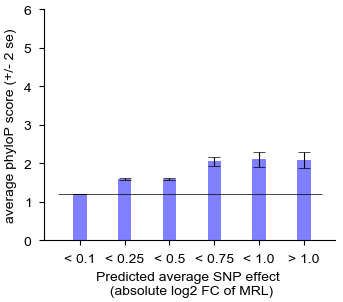

In [252]:
fig, ax = plt.subplots()

long_pos = x_pos
ax.bar(long_pos, scores_long, width=w, align='center', alpha=0.5, ecolor='black', capsize=10,
       color="blue", label="Frame-slice (>100 nt to TIS)")
(_, caps, _) = ax.errorbar(long_pos, scores_long, sem_long, capsize=capsize, ecolor = "k", fmt=' ')
for cap in caps:
    cap.set_color('k')
    cap.set_markeredgewidth(0.5)

    
# Labelling
ax.set_ylabel('average phyloP score (+/- 2 se)', fontsize=font_size)
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_xlabel("Predicted average SNP effect \n (absolute log2 FC of MRL)", fontsize=font_size)
ax.set_ylim((0,6))
ax.tick_params(labelsize=font_size)
#ax.legend(loc=(0.02,0.8), handletextpad=0.2, fontsize=font_size)
#ax.hlines(y=2,xmin=-0.5, xmax=5.4, linewidth=0.5)
ax.hlines(y=np.mean(arr_far["conservation"]),xmin=-0.5, xmax=5.4, linewidth=0.5)

fig.set_size_inches(fig_dims)

sns.despine(fig)

fig.savefig("../Graphics/phylop_bar_farPos.svg")

In [176]:
## Add counts in post
print(counts_paper)
print(counts)
print(counts_long)

[721903, 48870, 17081, 2647, 908, 247]
[719022, 46827, 21567, 2586, 1180, 477]
[1618941, 44841, 12511, 1487, 592, 320]


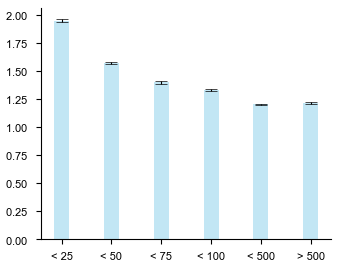

In [228]:
fig_dims = (3.75, 3.0)
font_size = 10
capsize = 4.5

scores = []
sem = []
cuts = [0, 25, 50, 75, 100, 500]
cuts2 = cuts[1:] + [1000000]
for l,u in zip(cuts, cuts2):
    scores.append(arr[(arr["dist_to_atg"] < u) & (arr["dist_to_atg"] > l)]["conservation"].mean())
    sem.append(arr[(arr["dist_to_atg"] < u) & (arr["dist_to_atg"] > l)]["conservation"].sem() * 2)
x_pos = np.arange(len(scores))
names = ["< " + str(x) for x in cuts2[:-1]] + ["> " + str(cuts[-1])]

fig, ax = plt.subplots()
our_pos = x_pos   
ax.bar(our_pos, scores, width=w, align='center', alpha=0.5, ecolor='black', capsize=10,
       color="skyblue")
(_, caps, _) = ax.errorbar(our_pos, scores, sem, capsize=capsize, ecolor = "k", fmt=' ')
for cap in caps:
    cap.set_color('k')
    cap.set_markeredgewidth(0.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(names)
    
fig.set_size_inches(fig_dims)

sns.despine(fig)

fig.savefig("../Graphics/phylop_by_dist.svg")

#### Variant Effects

In [599]:
def write_vareff(out_file, vcf, bed, model, min_len=None,
                postproc_mean=5.58621521, postproc_sd=1.34657403):
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    with open(out_file, 'w') as file:
        file.write("transcript_id\tvariant\tmrl_fc\tshift1\tshift2\tAC\tAN\tAF\n")
        for idx in range(len(bed)):
            entry_exons = bed["pos"].iloc[idx]
            entry_chr = bed["chr"].iloc[idx]
            entry_strand = bed["strand"].iloc[idx]
            entry_id = bed["id"].iloc[idx]

            # Find the variants and build reference sequence
            variants_dict = {}
            ref_exons_dict = collections.OrderedDict()
            for exon in entry_exons:
                # We get the interval
                interval = pybedtools.Interval(to_scalar(entry_chr), to_scalar(exon[0]), 
                                               to_scalar(exon[1]), strand=to_scalar(entry_strand))
                var_list = list(vcf.fetch_variants(interval))
                if len(var_list) > 0:
                    variants_dict[exon] = var_list
                # We get the reference sequence
                ref_exon = fasta_extractor.extract(interval)
                ref_exons_dict[exon] = ref_exon
            if len(variants_dict) == 0:
                continue
            
            # Assemble reference sequence
            ref_exons = [v for k,v in ref_exons_dict.items()]
            if entry_strand == "-":
                ref_exons.reverse()
            ref_seq = "".join(ref_exons)
            
            if len(ref_seq) < 4:
                continue
            
            # Insert the variants one by one
            var_sequences = []
            var_info_list = []
            for exon in variants_dict:
                # We get the interval
                interval = pybedtools.Interval(to_scalar(entry_chr), to_scalar(exon[0]), 
                                               to_scalar(exon[1]), strand=to_scalar(entry_strand))
                # Iterate through variants
                for v in variants_dict[exon]:
                    var_exon = vcf_extractor.extract(interval, variants=[v],
                        anchor=0, fixed_len=False)
                    var_string = "%s:%s:%s:['%s']" % (v.CHROM, str(v.POS),
                                           v.REF, v.ALT[0])
                    AC, AN, AF = 0, 0, 0
                    info = list(v.INFO)
                    for entry in info:
                        if entry[0] == "AC":
                            AC = entry[1]
                        if entry[0] == "AN":
                            AN = entry[1]
                        if entry[0] == "AF":
                            AF = entry[1]
                    # var seq
                    var_seq = []
                    for k,v in ref_exons_dict.items():
                        if k == exon:
                            var_seq.append(var_exon)
                        else:
                            var_seq.append(v)
                    if entry_strand == "-":
                        var_seq.reverse()
                    var_seq_combined = "".join(var_seq)
                    if len(var_seq_combined) < 4:
                        continue
                    var_sequences.append(var_seq_combined)
                    var_info_list.append({"AC": AC, "AN": AN, "AF": AF,
                                      "STR": var_string})
            
            # Predict and write
            sequences = [ref_seq] + var_sequences
            if len(sequences) == 1:
                continue
            df = pd.DataFrame({"utr":sequences})
            encoded_df = one_hot_fn(df)
            log2FC_shifts = []
            for shift in range(3):
                if shift > 0:
                    shifter = np.zeros((encoded_df.shape[0],1,4))
                    if min_len is not None:
                        encoded_df = np.concatenate([encoded_df[:,1:,:], shifter], axis=1)
                    else:
                        encoded_df = np.concatenate([encoded_df, shifter], axis=1)
                pred = model.predict(encoded_df).reshape(-1)
                if min_len is not None:
                    pred = pred * postproc_sd + postproc_mean
                log2FC_shifts.append(np.log2(pred[1:]/pred[0]))
            for i in range(len(var_info_list)):
                line = "%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (entry_id, 
                                                                     var_info_list[i]["STR"],
                                                            str(log2FC_shifts[0][i]),
                                                            str(log2FC_shifts[1][i]),
                                                            str(log2FC_shifts[2][i]),
                                                            str(var_info_list[i]["AC"]),
                                                            str(var_info_list[i]["AN"]),
                                                            str(var_info_list[i]["AF"]))
                file.write(line)

In [540]:
bed_file = "../kipoi/TestFiles/gencodev19_5utr_sorted.bed"
utr5_bed = pd.read_csv(bed_file, sep="\t", header=None)
tuples = list(zip(utr5_bed.iloc[:,1], utr5_bed.iloc[:,2]))
pos = [[x] for x in tuples]
id_chr_strand = list(zip(utr5_bed.iloc[:,3], utr5_bed.iloc[:,0],
                          utr5_bed.iloc[:,5]))
utr5_bed_posaggreg = pd.DataFrame({"pos":pos, "id_chr_strand": id_chr_strand})
utr5_bed_posaggreg = utr5_bed_posaggreg.groupby("id_chr_strand").agg({'pos': 'sum'})
utr5_bed_posaggreg["id"] = [x[0] for x in utr5_bed_posaggreg.index]
utr5_bed_posaggreg["chr"] = [x[1] for x in utr5_bed_posaggreg.index]
utr5_bed_posaggreg["strand"] = [x[2] for x in utr5_bed_posaggreg.index]
bed = utr5_bed_posaggreg.reset_index()[["id", "chr", "pos", "strand"]]

#### Gnomad

In [249]:
bed_list = []
for chrom in range(1,23):
    bed_chr = bed[bed.chr ==  str(chrom)]
    bed_list.append(bed_chr)

vcf_file_genome_base = "/s/genomes/human/hg19/gnomAD/vcf/gnomad.genomes.r2.1.1.sites."
vcf_genome_list = [vcf_file_genome_base + str(chrom) + ".vcf.bgz" for chrom in range(1,22)]

fasta_file = "/s/genomes/human/hg19/fasta/Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa"
fasta_extractor = FastaStringExtractor(fasta_file, use_strand=True,
                                    force_upper=True)
vcf_extractor = VariantSeqExtractor(fasta_file)

out_file_list = ["../Data/All_Variants/gnomad_vareff/gnomad_genome_" + str(chrom) + ".tsv" for 
                chrom in range(1,23)]

In [ ]:
##%%capture capt2
for i in range(len(bed_list)):
    write_vareff(out_file_list[i], MultiSampleVCF(vcf_genome_list[i]), bed_list[i])
    print("chr " + str(i) + " done")

In [263]:
out_file_list = ["../Data/All_Variants/gnomad_vareff/gnomad_genome_" + str(chrom) + ".tsv" for 
                chrom in range(1,23)]
gnomad_df_list = [pd.read_csv(out_file, sep="\t") for out_file in out_file_list]
gnomad_df = pd.concat(gnomad_df_list)

In [264]:
df_map = pd.read_csv("../kipoi/TestFiles/hg19_idmap.tsv", sep="\t")
gnomad_df = gnomad_df.merge(df_map, on="transcript_id")